<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_MNIST_DCGAN_ContentFehlt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement Deep Convolutional Generative Adversarial Nets (GAN) from [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) written by Alec Radford & Luke Metz. 

The dataset used in this notebook and other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU

# Setup

In [31]:
# for building GAN
from torchvision import transforms 
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.autograd import Variable 
import torch
import torch.nn as nn  


# for visualization
from torchvision.utils import save_image 
import numpy as np
from time import time #new
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from IPython.display import HTML
from torchvision.utils import make_grid
%matplotlib inline 

In [32]:
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
NUM_EPOCHS = 10 #can try 100 or 200 if technically possible
HIDDEN_DIM = 64
IM_CHANNEL = 1
Z_DIM= 100

In [33]:
#checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Getting data

In [34]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True)


In [35]:
def show_images(image_tensor, num_images=25, nrow=5, save=False): 
  image_tensor = image_tensor.detach().to('cpu') 
  # convert the output values to the expected range of float pixel values [0, 1]
  image_tensor = (image_tensor + 1)/2  
  img = make_grid(image_tensor[:num_images], nrow=nrow).permute(1,2,0).squeeze()
  # if save is True, just return the image  
  if save:
    return img
  plt.axis('off')
  plt.imshow(img)
  plt.show()

torch.Size([128, 1, 28, 28])


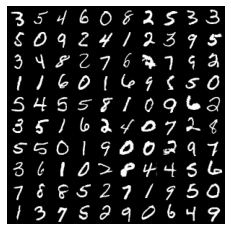

In [36]:
for i, data in enumerate(dataloader):
  X, _ = data  
  print(X.shape)
  break

show_images(X, 100, 10)

# Generator Model

https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

In [37]:
class Generator(nn.Module):
  '''
  z_dim: input noise vector 
  hidden_dim: size of the feature maps that are propagated through the generator, a scalar
  out_channel: number of channels in the output image
  '''
  def __init__(self, z_dim=100, hidden_dim=64, out_channel=1):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # layer 1, noise as input
        # can try hidden_dim * 16, *8 and * 4 or other structure
        self.generator_block(z_dim, hidden_dim*4, 4),
        
        self.generator_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),        
        
        self.generator_block(hidden_dim*2, hidden_dim, 4, 2, 2),                  
        
        self.generator_block(hidden_dim, out_channel, 4, 2, 1, last=True)        
        # Output 1 x 28 x 28
    )

  def generator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),        
          nn.BatchNorm2d(out_channels),
          nn.ReLU()        
      )
    else:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Tanh()
      )
    return gen_block


  def forward(self, X):
    return self.model(X)

From the DCGAN paper, the author suggested to initialize all weights from a zero-centered Normal distribution with standard deviation 0.02.

In [38]:
def init_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [40]:
gen = Generator(Z_DIM, HIDDEN_DIM)
gen.apply(init_weights)
print(gen)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


# Input noise vector

In [41]:
def noise_vector(num, dim):
  
  return torch.randn(num, dim, 1, 1) #shape: num, dim, 1, 1

# Discriminator Model

**Each layer of discriminator:**


*   Convolution for downsampling
*   Batchnormalization except for the last layer
*   LeakyReLU activation with slope = 0.2  




In [42]:
class Discriminator(nn.Module):
  '''
  im_channel: image_channel, number of channels in the input image. Default is 1 for black and white dataset, dataset with colors = 3
  hidden_dim: size of the feature maps that are propagated through the discriminator, a scalar
  '''
  def __init__(self, im_channel=1, hidden_dim=64):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        # Input: images of size 1 x 28 x 28
        self.discriminator_block(im_channel, hidden_dim, 4, 2, 1),        
        # after each layer hidded_dim will be doubled, img_shape will be flattened and reduced
        self.discriminator_block(hidden_dim, hidden_dim*2, 4, 2, 2),  #tried 4, 2, 1      
        # hidden_dim*2
        self.discriminator_block(hidden_dim*2, hidden_dim*4, 4, 2, 1),   
        # hidden_dim*4
        self.discriminator_block(hidden_dim*4, 1, 4, last=True)  
        # Sigmoid()      
    )

  def discriminator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.2)
      )
    else:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Sigmoid()
      )
    return disc_block
  
  def forward(self, image):
    out = self.model(image)
    return out.view(len(image), -1)

In [43]:
disc = Discriminator(IM_CHANNEL, HIDDEN_DIM)
disc.apply(init_weights)
print(disc)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)


# Start Training

Useful function:



*   [torch.optim.Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)




In [44]:
# initialize generator, discriminator, optimizer
gen = Generator(Z_DIM, HIDDEN_DIM).to(device) 
gen.apply(init_weights)

disc = Discriminator(IM_CHANNEL, HIDDEN_DIM).to(device)
disc.apply(init_weights)

optimG = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimD = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

gen.train()
disc.train()

criterion = nn.BCELoss()
fixed_noise = noise_vector(100, Z_DIM).to(device)


In [45]:
img_list = []
gen_losses = []
disc_losses = []
iter = 0
for epoch in range(NUM_EPOCHS):
  print('Epoch ' + str(epoch) + ' training...' , end=' ')
  start = time()
  for i, data in enumerate(dataloader):
    real = data[0].to(device)

    # update discriminator
    optimD.zero_grad()
    noise = noise_vector(len(real), 100).to(device)
    fake = gen(noise).detach()
    disc_fake_pred = disc(fake)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)    
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2

    # record discrimator loss for later visualization purpose
    disc_losses.append(disc_loss.item())
    # calculate gradients of discriminator
    disc_loss.backward()
    # update optimizer
    optimD.step()
    
    # update generator
    optimG.zero_grad()
    noise2 = noise_vector(len(real), 100).to(device)
    fake2 = gen(noise2)
    disc_fake_pred2 = disc(fake2)
    gen_loss = criterion(disc_fake_pred2, torch.ones_like(disc_fake_pred2))

    # record generator loss for later visualization purpose
    gen_losses.append(gen_loss.item())
    # calculate gradients of generator
    gen_loss.backward()
    # updatde optimizer
    optimG.step()

    # for every 250 iterations or the last batch of data in the last epoch,
    # use the fixed_noise to generate fake images to see the generator's learning progress   
    if iter % 250 == 0 or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader) - 1)):
      with torch.no_grad():
        fixed_fake = gen(fixed_noise)
        img = show_images(fixed_fake, len(fixed_fake), nrow=10, save=True)        
        img_list.append(img)
    iter+=1
  # training status
  print('[{}/{}]\tLoss_D: {:.5f}\tLoss_G: {:.5f}\tD(x): {:.5f}\tD(G(z)): {:.5f}/{:.5f}'.format(epoch+1, NUM_EPOCHS, disc_loss.item(), gen_loss.item(), disc_real_pred.mean().item(), disc_fake_pred.mean().item(), disc_fake_pred2.mean().item()))
  end = time()
  elapsed = end - start
  print('done, took %.1f seconds.' % elapsed)


Epoch 0 training... [1/10]	Loss_D: 0.08278	Loss_G: 1.08447	D(x): 0.96165	D(G(z)): 0.11758/0.35057
done, took 73.4 seconds.
Epoch 1 training... [2/10]	Loss_D: 0.21822	Loss_G: 3.00964	D(x): 0.90019	D(G(z)): 0.27046/0.05894
done, took 72.2 seconds.
Epoch 2 training... [3/10]	Loss_D: 0.35938	Loss_G: 1.28799	D(x): 0.64027	D(G(z)): 0.19734/0.30440
done, took 72.0 seconds.
Epoch 3 training... [4/10]	Loss_D: 0.38938	Loss_G: 1.79896	D(x): 0.77147	D(G(z)): 0.37991/0.19465
done, took 72.0 seconds.
Epoch 4 training... [5/10]	Loss_D: 0.46028	Loss_G: 2.36929	D(x): 0.83964	D(G(z)): 0.49310/0.11391
done, took 71.9 seconds.
Epoch 5 training... [6/10]	Loss_D: 0.33934	Loss_G: 1.53430	D(x): 0.76743	D(G(z)): 0.30063/0.24000
done, took 72.0 seconds.
Epoch 6 training... [7/10]	Loss_D: 0.36668	Loss_G: 1.80925	D(x): 0.79620	D(G(z)): 0.35846/0.20510
done, took 72.0 seconds.
Epoch 7 training... [8/10]	Loss_D: 0.38290	Loss_G: 1.51556	D(x): 0.72689	D(G(z)): 0.32709/0.25513
done, took 71.9 seconds.
Epoch 8 training

# Visualization

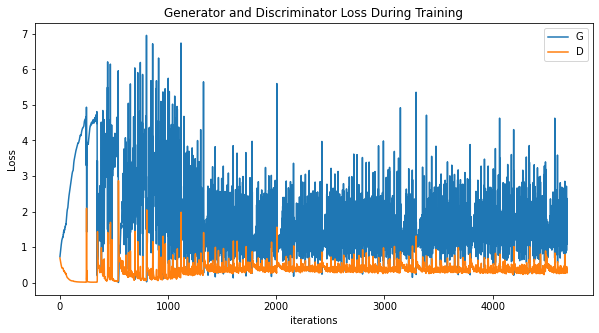

In [49]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

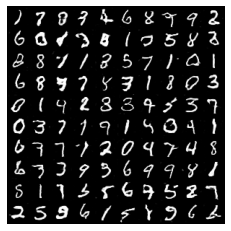

In [50]:
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_html5_video())

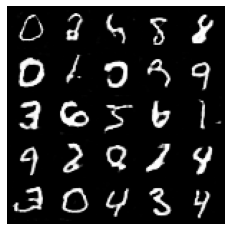

In [51]:
#Using the generator after training to generate fake fotos
noise = noise_vector(25, Z_DIM).to(device)
show_images(gen(noise))

# Summary



